# Final Project

In [1]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from sklearn.metrics import accuracy_score
from keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, LSTM
import tensorflow as tf

# 1. Text Classification


### It is highly recommended that you complete this project using Keras1 and Python.
### (a) In this problem, we are trying to build a classifier to analyze the sentiment of reviews. 
### You are provided with text data in two folders: one folder involves positive reviews, and one folder involves negative reviews.

# (b) Data Exploration and Pre-Processing

### i. You can use binary encoding for the sentiments , i.e y = 1 for positive sentiments and y = −1 for negative sentiments.

### ii. The data are pretty clean. Remove the punctuation and numbers from the data.

### iii. The name of each text file starts with cv number. Use text files 0-699 in each class for training and 700-999 for testing.


The function below takes in the file path and the encoding value.
The files in the directory (pos or neg) are listed and iterated through and separated into test and train based on the three digit number following "cv" in the file name. The data is then cleaned of punctuation, and numbers. The data is then zipped together with its encoding value and the train and test with encoding (labeling) is returned.

In [23]:
def clean_split_encode_files(filepath,encode):
    files = os.listdir(filepath)
    train_files = []
    test_files = []
    for file in files:
            file_number = int(file[2:5]) 
            if 0 <= file_number < 700:
                train_files.append(file)
            elif 700 <= file_number <= 999:
                test_files.append(file)

    train_data = [open(os.path.join(filepath, file), 'r', encoding='utf-8').read() for file in train_files]
    train_data = [re.sub(r'\d+', '', word) for word in train_data]
    train_data = [re.sub(r'[^\w\s]', ' ', word) for word in train_data]
    train_data = [word.lower() for word in train_data]
    train_data = [word.replace('\n', ' ') for word in train_data]
    train_data = [word.replace("_", " ") for word in train_data]
    train_data = [word.replace("-", " ") for word in train_data]
    train_labeled = [(text, encode) for text in train_data]

    test_data = [open(os.path.join(filepath, file), 'r', encoding='utf-8').read() for file in test_files]
    test_data = [re.sub(r'\d+', '', word) for word in test_data]
    test_data = [re.sub(r'[^\w\s]', ' ', word) for word in test_data]
    test_data = [word.lower() for word in test_data]
    test_data = [word.replace('\n', ' ') for word in test_data]
    test_data = [word.replace("_", " ") for word in test_data]
    test_data = [word.replace("-", " ") for word in test_data]
    test_labeled = [(text, encode) for text in test_data]
    
    return train_labeled, test_labeled

After much trial and error with using -1 and 1, I ultimately altered the encoding to 0 and 1 to be compatible with the sigmoid activation function and binary cross entropy loss function. I had previusly attempted to use tanh for the activation function, however after trying binary cross entropy, hinge, etc as the loss function, I could not determine a valid loss function to use. Binary cross entropy expects the output to be a binary 0 and 1 so i thought it made the most sense to change the encoding for valid results.

In [28]:
neg_train,neg_test = clean_split_encode_files("../Data/neg",0)
pos_train,pos_test = clean_split_encode_files("../Data/pos",1)
train_data = neg_train + pos_train
test_data = neg_test + pos_test
print(len(train_data))
print(len(test_data))

1400
600


### iv. Count the number of unique words in the whole dataset (train + test) and print it out.

In [25]:
total_data = train_data + test_data
unique_words = set()
for text, label in total_data:
    words = text.lower().split()
    unique_words.update(words) 
print(f"Unique Word Count: {len(unique_words)} words")

Unique Word Count: 38916 words


There are 38,916 unique words in the total dataset.

### v. Calculate the average review length and the standard deviation of review lengths. Report the results.

In [26]:
review_lengths = [len(review.split()) for review, sentiment in total_data]
average_review = np.mean(review_lengths)
std_review = np.std(review_lengths)
print(f"Average review length: {round(average_review,2)} words")
print(f"Standard deviation review length: {round(std_review,2)} words")

Average review length: 665.61 words
Standard deviation review length: 293.65 words


On average, a review length is 665.61 words and the standard deviation of review length is 293.65 words

### vi. Plot the histogram of review lengths.

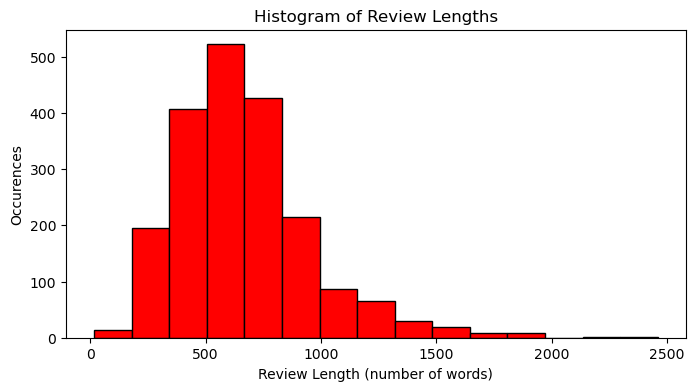

In [6]:
plt.figure(figsize=(8, 4))
plt.hist(review_lengths, bins=15, color='red', edgecolor='black') 
plt.title('Histogram of Review Lengths')
plt.xlabel('Review Length (number of words)')
plt.ylabel('Occurences')
plt.show()

From the histogram, we can see a lot of occurences around 500 to 600 words which is relatively close to the average. The review lengths appear to follow a normal distribution. This is because the shape of the histogram follows a bell curve with possibly a small amount of right skewness as there appears to be more occurences of data concentrated on the left side of the distribution.

### viii. Select a review length L that 70% of the reviews have a length below it. If you feel more adventurous, set the threshold to 90%.

In [7]:
percentile70_review = np.percentile(review_lengths,70)
percentile70_review

759.3

The 70th percentile review length is 759.3 (rounded to 760) which means that roughly 70% of review lengths are under 760 words.

In [8]:
L = 760

### vii. To represent each text (= data point), there are many ways. In NLP/Deep Learning terminology, this task is called tokenization. It is common to rep- resent text using popularity/ rank of words in text. The most common word in the text will be represented as 1, the second most common word will be represented as 2, etc. Tokenize each text document using this method.

### ix. Truncate reviews longer than L words and zero-pad reviews shorter than L so that all texts (= data points) are of length L.

In [9]:
# tokenization of total data set combined
reviews = [text for text, sentiment in total_data]
sentiments = [sentiment for text, sentiment in total_data]
tokenizer = Tokenizer()
tokenizer.fit_on_texts(reviews)

ranks = tokenizer.texts_to_sequences(reviews)
ranked_data = [(" ".join(str(item) for item in rank), sentiment) for rank, sentiment in zip(ranks, sentiments)]
ranked_data[:2]

[('108 108 108 10 25 601 140 5 275 70 5431 44 794 1 5630 4 1 6396 55 10 7711 166 22 156 13 30 97 43 22 2 22 2 22 2 138 906 22 297 1 215 75 61 119 8685 3285 8 13021 13 1085 1657 816 10795 500 28 904 5877 1 13022 1458 25344 4584 39 6 93 60 25 75 310 5 1294 59 569 2 181 32 15 26 10 6 1 185 10 9 33 574 338 23 5432 16 1946 1329 3428 28 73 33 1889 13 1 469 83 287 15 26 30 67 110 24 411 5 972 124 129 25 4 14 1513 100 18 283 2 26 2 6693 149 13 108 701 12 2 702 394 15 26 6397 42 1189 220 2385 15 26 1240 2 19 39 21 686 4 9 10 21 41 108 35 21 182 176 41 17 203 657 9 2 3 406 10 6 90 7322 189 31 1 450 693 17 1134 10 17 94 2 848 2 2205 20 109 954 29 60 21 1 85 1 693 179 402 2916 19 1 82 107 30 84 1271 2 134 10795 201 264 111 4458 23 2 219 7 2 3208 6694 17 94 757 62 365 163 1 578 10 33 1917 9 92 74 1947 368 3 11 347 11 1 82 107 6 102 56 690 5 2 308 6398 107 5 24 1676 11 17 2792 124 15 26 16731 23 53 97 1126 1065 9 33 17 179 3663 43 1 1127 42 4 238 450 315 9 10796 44 210 368 7 1 16 12 1 727 4 1 701 22

In [34]:
train_reviews = [text for text,sentiment in train_data]
train_sentiments = [sentiment for text, sentiment in train_data]
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_reviews)

train_ranks = tokenizer.texts_to_sequences(train_reviews)
train_ranked_data = [(" ".join(str(item) for item in rank), sentiment) for rank, sentiment in zip(train_ranks, train_sentiments)]

# L defined earlier with 70th percentile
x_train = pad_sequences(train_ranks,maxlen=L, padding='post',truncating='post')
y_train = [sentiment for text, sentiment in train_ranked_data]

# convert sentiments to np array for compatibility
y_train = np.array(y_train)

x_train[:2]

array([[  108,   108,   108, ...,    51,    75, 11874],
       [ 6461,     6,    29, ...,     0,     0,     0]], dtype=int32)

In [11]:
# tokenization and padding performed on train and test separately
test_reviews = [text for text,sentiment in test_data]
test_sentiments = [sentiment for text, sentiment in test_data]
tokenizer = Tokenizer()
tokenizer.fit_on_texts(test_reviews)

test_ranks = tokenizer.texts_to_sequences(test_reviews)
test_ranked_data = [(" ".join(str(item) for item in rank),sentiment) for rank, sentiment in zip(test_ranks,test_sentiments)]
x_test = pad_sequences(test_ranks, maxlen=L, padding='post',truncating='post')
y_test = [sentiment for text, sentiment in test_ranked_data]

# convert the sentiments to array
y_test = np.array(y_test)

x_test[:2]

array([[ 155,   22,   10, ...,    0,    0,    0],
       [2537, 3464, 7006, ...,    0,    0,    0]], dtype=int32)

# (c) Word Embeddings

### i. One can use tokenized text as inputs to a deep neural network. However, a re- cent breakthrough in NLP suggests that more sophisticated representations of text yield better results. These sophisticated representations are called word embeddings. “Word embedding is a term used for representation of words for text analysis, typically in the form of a real-valued vector that encodes the meaning of the word such that the words that are closer in the vectorspace are expected to be similar in meaning.”. Most deep learning modules (including Keras) provide a convenient way to convert positive integer rep- resentations of words into a word embedding by an “Embedding layer.” The layer accepts arguments that define the mapping of words into embeddings, including the maximum number of expected words also called the vocabulary size (e.g. the largest integer value). The layer also allows you to specify the dimension for each word vector, called the “output dimension.” We would like to use a word embedding layer for this project. Assume that we are interested in the top 5,000 words. This means that in each integer sequence that represents each document, we set to zero those integers that represent words that are not among the top 5,000 words in the document. If you feel more adventurous, use all the words that appear in this corpus. Choose the length of the embedding vector for each word to be 32. Hence, each document is represented as a 32 × L matrix.

### ii. Flatten the matrix of ach document to a vector.

In [12]:
embedded_model = Sequential()
embedded_model.add(Embedding(input_dim=5000,output_dim=32,input_length=L))
embedded_model.add(Flatten())
embedded_model.add(Dense(1,activation='sigmoid'))

embedded_model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
# perform validation on small subset of train data
embedded_model.fit(x_train, y_train,epochs=2,validation_split=0.1)

Epoch 1/2


2024-05-07 13:55:48.437357: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2024-05-07 13:55:48.437377: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-05-07 13:55:48.437382: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-05-07 13:55:48.437408: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-05-07 13:55:48.437420: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2024-05-07 13:55:48.762746: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


40/40 [==============================] - 1s 22ms/step - loss: 0.6848 - accuracy: 0.5683 - val_loss: 0.7500 - val_accuracy: 0.2286
Epoch 2/2
 4/40 [==>...........................] - ETA: 0s - loss: 0.6042 - accuracy: 0.8672

2024-05-07 13:55:49.735027: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


40/40 [==============================] - 1s 18ms/step - loss: 0.5884 - accuracy: 0.8246 - val_loss: 0.7867 - val_accuracy: 0.3071


# (d) Multi-Layer Perceptron

### i. Train a MLP with three (dense) hidden layers each of which has 50 ReLUs and one output layer with a single sigmoid neuron. Use a dropout rate of 20% for the first layer and 50% for the other layers. Use ADAM optimizer and binary cross entropy loss (which is equivalent to having a softmax in the output). To avoid overfitting, just set the number of epochs as 2. Use a batch size of 10.

In [32]:
mlp_model = Sequential()
mlp_model.add(Embedding(input_dim=5000,output_dim=32, input_length=L))
mlp_model.add(Flatten()) # dropout of 0.2 for first layer and 0.5 for other layers
mlp_model.add(Dense(50, activation='relu'))
mlp_model.add(Dropout(0.2))
mlp_model.add(Dense(50, activation='relu'))
mlp_model.add(Dropout(0.5))
mlp_model.add(Dense(50, activation='relu'))
mlp_model.add(Dropout(0.5))
mlp_model.add(Dense(1,activation='sigmoid'))

mlp_model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
mlp_model.fit(x_train,y_train, epochs=2, batch_size=10,validation_split=0.1)

Epoch 1/2


2024-05-07 15:46:06.980435: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


126/126 [==============================] - ETA: 0s - loss: 0.7221 - accuracy: 0.5206

2024-05-07 15:46:12.098960: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


126/126 [==============================] - 6s 37ms/step - loss: 0.7221 - accuracy: 0.5206 - val_loss: 0.7037 - val_accuracy: 0.4643
Epoch 2/2
126/126 [==============================] - 4s 29ms/step - loss: 0.5739 - accuracy: 0.6817 - val_loss: 0.9124 - val_accuracy: 0.2786


### ii. Report the train and test accuracies of this model.

In [33]:
# a threshold of 0.5 was used to convert predictions
train_predictions = mlp_model.predict(x_train)
binary_train_predictions = (train_predictions >= 0.5).astype(int)
train_accuracy = accuracy_score(y_train, binary_train_predictions)
print(f"Train Accuracy: {round(train_accuracy,3)}")

test_predictions = mlp_model.predict(x_test)
binary_test_predictions = (test_predictions >= 0.5).astype(int)
test_accuracy = accuracy_score(y_test, binary_test_predictions)
print(f"Test Accuracy: {round(test_accuracy,3)}")

44/44 [==============================] - 0s 2ms/step
Train Accuracy: 0.824
19/19 [==============================] - 0s 2ms/step


2024-05-07 15:46:18.479963: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Test Accuracy: 0.528


The Multi Layer Perceptron model achieved a relatively high train accuracy of 0.824 but a much lower test accuracy of 0.528. This model was run several times and produced a train accuracy in the range of 0.65 to 0.88. The test accuracy range is consistently around 0.50 to 0.60. In one run, the train accuracy reached as high as 0.889, however the test accuracy for this run was around 0.47 which indicates some degree of overfitting.

# (e) One-Dimensional Convolutional Neural Network:

#### Although CNNs are mainly used for image data, they can also be applied to text data, as text also has adjacency information. Keras supports one-dimensional convolutions and pooling by the Conv1D and MaxPooling1D classes respectively.

### i. After the embedding layer, insert a Conv1D layer. This convolutional layer has 32 feature maps , and each of the 32 kernels has size 3, i.e. reads embedded word representations 3 vector elements of the word embedding at a time. The convolutional layer is followed by a 1D max pooling layer with a length and stride of 2 that halves the size of the feature maps from the convolutional layer. The rest of the network is the same as the neural network above.

In [15]:
# one embedded layer, a Conv1D layer 
# stride defaults to same value as pool_size
cnn_model = Sequential()
cnn_model.add(Embedding(input_dim=5000,output_dim=32, input_length=L))
cnn_model.add(Conv1D(filters=32,kernel_size=3, activation='relu'))
cnn_model.add(MaxPooling1D(pool_size=2))
cnn_model.add(Flatten())
cnn_model.add(Dense(50, activation='relu'))
cnn_model.add(Dropout(0.2))
cnn_model.add(Dense(50, activation='relu'))
cnn_model.add(Dropout(0.5))
cnn_model.add(Dense(50, activation='relu'))
cnn_model.add(Dropout(0.5))
cnn_model.add(Dense(1,activation='sigmoid'))

cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [16]:
# perform validation done on small subset of train data
cnn_model.fit(x_train,y_train,epochs=2, batch_size=10,validation_split=0.1)

Epoch 1/2


2024-05-07 13:55:56.335385: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


126/126 [==============================] - 4s 25ms/step - loss: 0.7458 - accuracy: 0.5262 - val_loss: 0.8233 - val_accuracy: 0.0000e+00
Epoch 2/2
  1/126 [..............................] - ETA: 3s - loss: 0.6857 - accuracy: 0.4000

2024-05-07 13:55:59.525276: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


126/126 [==============================] - 3s 22ms/step - loss: 0.6865 - accuracy: 0.5627 - val_loss: 0.5235 - val_accuracy: 1.0000


### ii. Report the train and test accuracies of this model.

In [17]:
train_predictions = cnn_model.predict(x_train)
binary_train_predictions = (train_predictions >= 0.5).astype(int)
train_accuracy = accuracy_score(y_train, binary_train_predictions)
print(f"Train Accuracy: {round(train_accuracy,3)}")

test_predictions = cnn_model.predict(x_test)
binary_test_predictions = (test_predictions >= 0.5).astype(int)
test_accuracy = accuracy_score(y_test, binary_test_predictions)
print(f'Test Accuracy: {round(test_accuracy,3)}')

44/44 [==============================] - 0s 2ms/step
Train Accuracy: 0.502
 1/19 [>.............................] - ETA: 0s

2024-05-07 13:56:02.470715: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


19/19 [==============================] - 0s 2ms/step
Test Accuracy: 0.5


The train and test accuracy of the 1D CNN model is consistently about 0.5.

# (f) Long Short-Term Memory Recurrent Neural Network:

### i. Each word is represented to LSTM as a vector of 32 elements and the LSTM is followed by a dense layer of 256 ReLUs. Use a dropout rate of 0.2 for both LSTM and the dense layer. Train the model using 10-50 epochs and batch size of 10.

In [18]:
# dense layer of 256 ReLUs
lstm_model = Sequential()
lstm_model.add(Embedding(input_dim=5000,output_dim=32,input_length=760))
lstm_model.add(LSTM(256))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(256,activation='relu'))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(1, activation='sigmoid'))

lstm_model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [19]:
lstm_model.fit(x_train, y_train,epochs=50, batch_size=10, validation_split=0.1)

Epoch 1/50


2024-05-07 13:56:03.235394: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-07 13:56:03.342527: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  1/126 [..............................] - ETA: 2:02 - loss: 0.6926 - accuracy: 0.6000

2024-05-07 13:56:03.636551: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


126/126 [==============================] - ETA: 0s - loss: 0.6866 - accuracy: 0.5571

2024-05-07 13:56:11.027262: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-07 13:56:11.074636: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


126/126 [==============================] - 9s 62ms/step - loss: 0.6866 - accuracy: 0.5571 - val_loss: 0.7769 - val_accuracy: 0.2500
Epoch 2/50
126/126 [==============================] - 8s 61ms/step - loss: 0.6746 - accuracy: 0.6127 - val_loss: 0.8742 - val_accuracy: 0.2214
Epoch 3/50
126/126 [==============================] - 8s 61ms/step - loss: 0.6171 - accuracy: 0.6611 - val_loss: 0.8831 - val_accuracy: 0.1571
Epoch 4/50
126/126 [==============================] - 8s 61ms/step - loss: 0.5986 - accuracy: 0.6730 - val_loss: 0.7393 - val_accuracy: 0.8357
Epoch 5/50
126/126 [==============================] - 8s 62ms/step - loss: 0.5908 - accuracy: 0.6429 - val_loss: 1.7927 - val_accuracy: 0.2214
Epoch 6/50
126/126 [==============================] - 8s 63ms/step - loss: 0.5362 - accuracy: 0.6865 - val_loss: 1.1538 - val_accuracy: 0.1286
Epoch 7/50
126/126 [==============================] - 8s 62ms/step - loss: 0.6000 - accuracy: 0.6563 - val_loss: 1.0061 - val_accuracy: 0.1571
Epoch 8/50

Up until about 10 epochs (which represent forward and back passes through the network) the accurracy steadily increases. After 10 epochs, the accuracy begins to plateau and the validation accuracy begins to decrease. This indicates some degree of overfitting to the data. After 10 epochs, the network does not learn much more from the dataset as seen by the steady accuracy.

The validation accuracy also begins to decline after about 20 epochs while accuracy increases ever so slightlly which may also indicate overfitting.

### ii. Report the train and test accuracies of this model.

In [20]:
train_predictions = lstm_model.predict(x_train)
binary_train_predictions = (train_predictions >= 0.5).astype(int)
train_accuracy = accuracy_score(y_train, binary_train_predictions)
print(f'Train Accuracy: {round(train_accuracy,3)}')

test_predictions = lstm_model.predict(x_test)
binary_test_predictions =(test_predictions>= 0.5).astype(int)
test_accuracy = accuracy_score(y_test, binary_test_predictions)
print(f"Test Accuracy: {round(test_accuracy,3)}")

2024-05-07 14:02:34.453495: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-07 14:02:34.508036: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


44/44 [==============================] - 1s 24ms/step
Train Accuracy: 0.609
19/19 [==============================] - 0s 21ms/step
Test Accuracy: 0.482


The train accuracy for LSTM model is 0.609 and the test accuracy is 0.482. After running multiple times, the train accuracy for the LSTM model is roughly in the range of 0.6 to 0.74 and the test accuracy is in the range of 0.46-0.55.

# References

Cleaning: https://stackoverflow.com/questions/44494431/how-to-list-files-in-a-directory-in-python

https://stackoverflow.com/questions/71131172/replace-matched-susbtring-using-re-sub

Binary Cross Entropy: https://www.tensorflow.org/api_docs/python/tf/keras/losses/BinaryCrossentropy

Embedded Layer: https://stackoverflow.com/questions/45649520/explain-with-example-how-embedding-layers-in-keras-works

1D CNN: https://stackoverflow.com/questions/73851855/1d-cnn-using-tensorflow-keras-classification-problems

LSTM: https://github.com/christianversloot/machine-learning-articles/blob/main/build-an-lstm-model-with-tensorflow-and-keras.md